In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)


In [2]:
df_matches = pd.read_csv("data/matches.csv", index_col="id")
df_teams = pd.read_csv("data/teams.csv", index_col="team")

# Matches

Text(0, 0.5, 'Count')

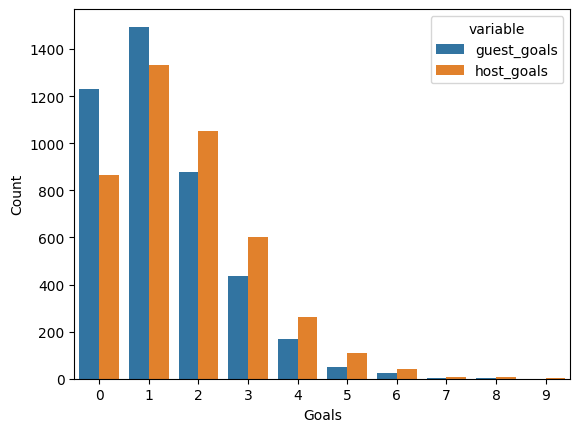

In [3]:
goals_long = df_matches[["host_goals", "guest_goals"]].melt().value_counts().reset_index()
ax = sns.barplot(goals_long, x="value", y="count", hue="variable")
ax.set_xlabel("Goals")
ax.set_ylabel("Count")

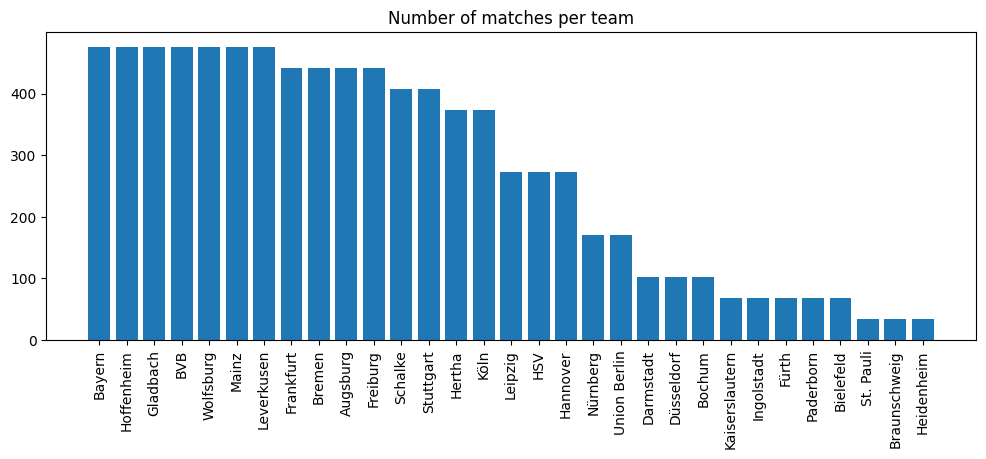

In [4]:
matches_per_team = {}
for name, n_matches in df_matches["host_name"].value_counts().to_dict().items():
    matches_per_team[name] = n_matches

for name, n_matches in df_matches["guest_name"].value_counts().to_dict().items():
    if name not in matches_per_team:
        matches_per_team[name] = 0
    matches_per_team[name] += n_matches

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Number of matches per team")
ax.bar(matches_per_team.keys(), matches_per_team.values())
ax.set_xticks(range(len(matches_per_team.keys())), matches_per_team.keys(), rotation=90, ha='center')
!

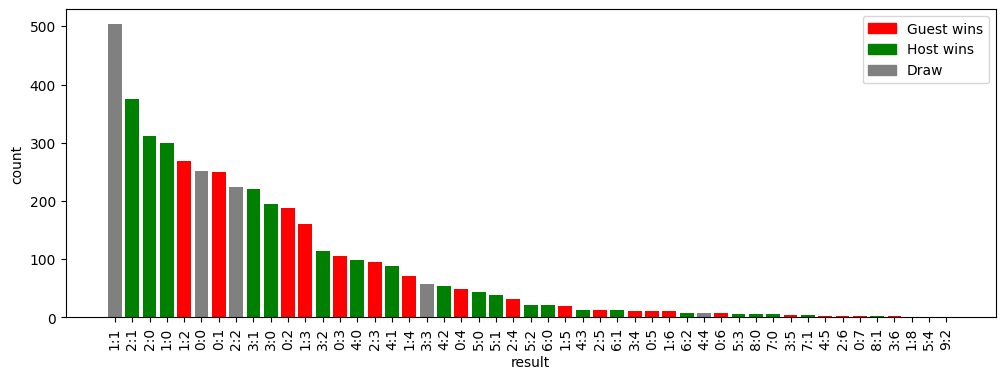

In [5]:
goals_encoded = [f"{r[0]}:{r[1]}" for r in df_matches[["host_goals", "guest_goals"]].values]
results, counts = np.unique(goals_encoded, return_counts=True)
sort = np.argsort(-counts)
counts = counts[sort]
results = results[sort]
tendency = [1] * len(results)
for i, res in enumerate(results):
    goals = res.split(":")
    if goals[0] > goals[1]:
        tendency[i] = 0
    elif goals[0] < goals[1]:
        tendency[i] = 2

y_test_colors = [["green", "gray", "red"][r] for r in tendency]
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(len(results)), counts, color=y_test_colors)
ax.set_xlabel("result")
ax.set_ylabel(f"count")
ax.set_xticks(range(len(results)), results, rotation=90)

red_patch = mpatches.Patch(color='red', label='Guest wins')
green_patch = mpatches.Patch(color='green', label='Host wins')
gray_patch = mpatches.Patch(color='gray', label='Draw')
ax.legend(handles=[red_patch, green_patch, gray_patch])

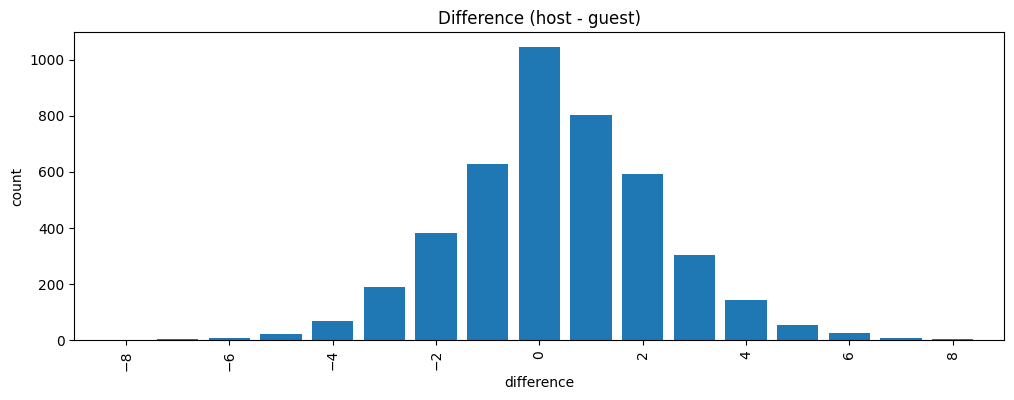

In [8]:
diff_counts = (df_matches["host_goals"] - df_matches["guest_goals"]).value_counts()
plt.figure(figsize=(12, 4))
plt.bar(diff_counts.index, diff_counts.values)
plt.xticks(rotation=90)
plt.title("Difference (host - guest)")
plt.ylabel("count")
plt.xlabel("difference")
plt.xlim(-9, 9)
!

# Teams

In [9]:
df_team_names = df_matches[["host_id", "host_name"]].drop_duplicates().rename(columns={"host_id": "team_id", "host_name": "name"}).reset_index(drop=True)
df_team_names.tail()

,team_id,name
27,1635,Leipzig
28,80,Union Berlin
29,83,Bielefeld
30,129,Bochum
31,199,Heidenheim


In [225]:
df_team_stats = pd.merge(left=df_teams.groupby(["team"]).mean(), left_index=True, right=df_team_names, right_on="team_id")[["name", "points", "wins", "draws", "defeats", "goals", "opponent_goals"]]
df_team_stats = df_team_stats.sort_values(by="points", ascending=False)
df_team_stats.head()

,name,points,wins,draws,defeats,goals,opponent_goals
0,Bayern,79.29,24.79,4.93,4.29,90.07,29.71
8,BVB,67.71,20.36,6.64,7.00,74.93,40.00
27,Leipzig,63.25,18.38,8.12,7.50,67.50,38.38
16,Leverkusen,60.14,17.57,7.43,9.00,62.79,42.79
2,Gladbach,50.14,13.93,8.36,11.71,54.29,48.50


<Axes: >

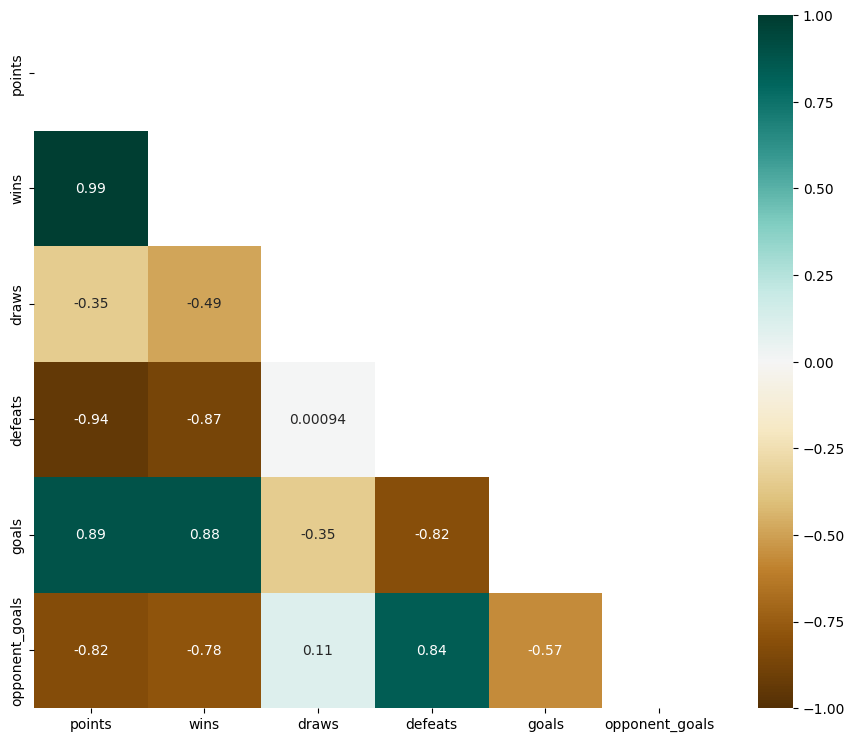

In [10]:
corr = df_teams[["points", "wins", "draws", "defeats", "goals", "opponent_goals"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, cmap='BrBG')

# Historic Relationships

252
202


<Axes: >

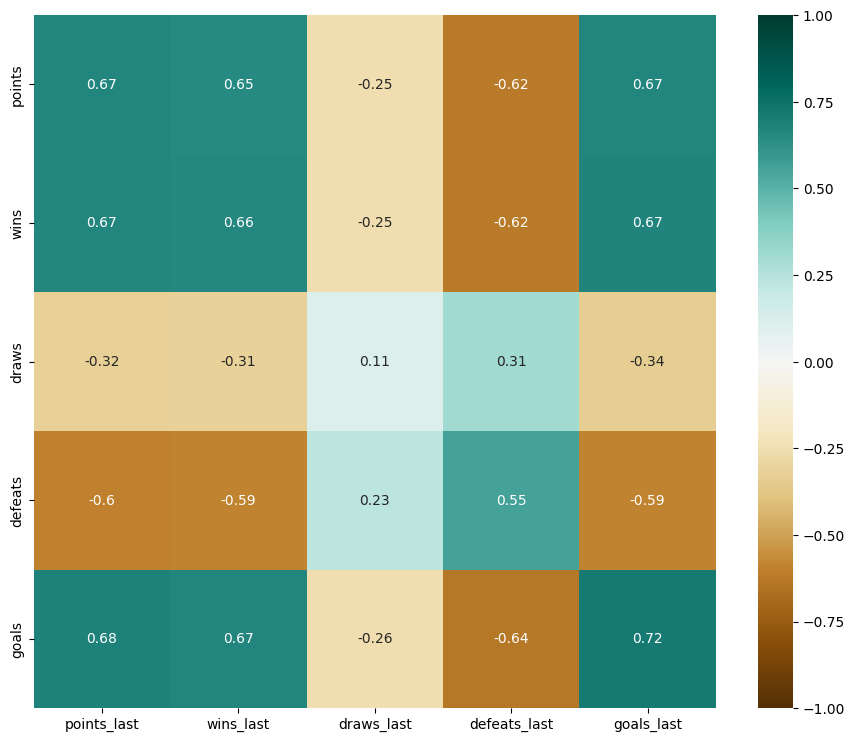

In [11]:
df_teams_last_season = df_teams.copy()
df_teams_last_season["year"] += 1

df_teams_with_last = pd.merge(left=df_teams, right=df_teams_last_season, on=["team", "year"], suffixes=("", "_last"), how="left")
print(len(df_teams_with_last))
df_teams_with_last = df_teams_with_last.dropna()
print(len(df_teams_with_last))
corr = df_teams_with_last[["points", "points_last", "wins", "wins_last", "draws", "draws_last", "defeats", "defeats_last", "goals", "goals_last"]].corr()
corr = corr.drop(columns=["points", "wins", "goals", "draws", "defeats"])
corr = corr.drop(["points_last", "wins_last", "goals_last", "draws_last", "defeats_last"])

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='BrBG')